# Captcha Image Analysis

In [1]:
# Load packages
import os
import warnings
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load and check training data from "sampleCaptchas" folder
- Search all images in "input" folder.
- Images without input or output text file will be moved into test dataset.

In [2]:
train_img_list = []
train_txt_list = []
label_txt_list = []
test_img_list = []
train_path = './sampleCaptchas'
for img_file in sorted(glob(train_path + '/input/*.jpg')):
    input_txt = img_file.replace('.jpg', '.txt')
    output_txt = input_txt.replace('input', 'output')
    if os.path.exists(input_txt):
        if os.path.exists(output_txt):
            train_img_list.append(img_file)
            train_txt_list.append(input_txt)
            label_txt_list.append(output_txt)
        else:
            warnings.warn(f'Could not find file "{output_txt}".', UserWarning)
            test_img_list.append(img_file)
    else:
        warnings.warn(f'Could not find file "{input_txt}".', UserWarning)
        test_img_list.append(img_file)

/tmp/ipykernel_3579110/4132654970.py:18: UserWarning: Could not find file "./sampleCaptchas/input/input100.txt".
  warnings.warn(f'Could not find file "{input_txt}".', UserWarning)
/tmp/ipykernel_3579110/4132654970.py:15: UserWarning: Could not find file "./sampleCaptchas/output/output21.txt".
  warnings.warn(f'Could not find file "{output_txt}".', UserWarning)


- Load the image and check if its height and width match the values in its corresponding intput text file.
- Check whether each pixel in the image matches the values in its corresponding intput text file.
- We found that each pixel in the image has identical values across blue, green and red channels.

In [3]:
skipped = []
for i, img_file in enumerate(train_img_list):
    input_txt = train_txt_list[i]
    output_txt = label_txt_list[i]
    img = cv2.imread(img_file)
    h, w, c = img.shape

    with open(input_txt, 'r') as f:
        input_meta = f.readlines()
    with open(output_txt, 'r') as f:
        label = f.read().strip()
    h_meta, w_meta = input_meta[0].strip().split(' ')
    if not int(h_meta) == h or not int(w_meta) == w:
        warnings.warn(f'''
            Found resolution mismatch: "{img_file}": Meta data: ({h_meta}, {w_meta}), image resolution: ({h}, {w}).
        ''', UserWarning)
        skipped.append(i)
        continue

    pixel_meta = []
    for i_h, line_h in enumerate(input_meta[1:]):
        for i_w, line_w in enumerate(line_h.strip().split(' ')):
            b, g, r = img[i_h, i_w, :]
            b_meta, g_meta, r_meta = line_w.strip().split(',')
            assert b == g == r
            assert int(b_meta) == b and int(g_meta) == g and int(r_meta) == r
            pixel_meta.append(b)

pixel_meta = np.array(pixel_meta)
test_img_list += [train_img_list[i] for i in skipped]
train_img_list = [train_img_list[i] for i in range(len(train_img_list)) if i not in skipped]
train_txt_list = [train_txt_list[i] for i in range(len(train_txt_list)) if i not in skipped]
label_txt_list = [label_txt_list[i] for i in range(len(label_txt_list)) if i not in skipped]
print(f'Skipped images: {test_img_list}.')
print(f'{len(train_img_list)} training images enrolled.')

Skipped images: ['./sampleCaptchas/input/input100.jpg', './sampleCaptchas/input/input21.jpg'].
24 training images enrolled.


## Convert image into binary map and segment it into characters
- Count the values of all pixels from training images and plot a histogram.
- From the histogram, we found that the pixel values of the characters are all below 40 and differ significantly from the pixel values of the background and noise.

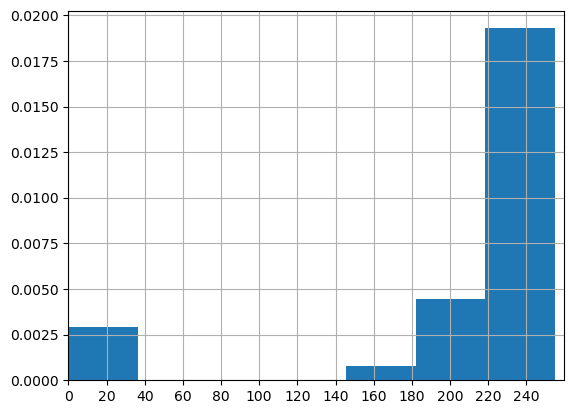

In [4]:
plt.hist(pixel_meta, 7, density=True)
plt.xticks(np.arange(0, 260, 20))
plt.xlim(0, 260)
plt.grid(True)
plt.show() 

- Set the threshold to 40.
- Take the first captcha as an example. Convert the image into a binary map which is easier to process.

In [5]:
threshold = 40

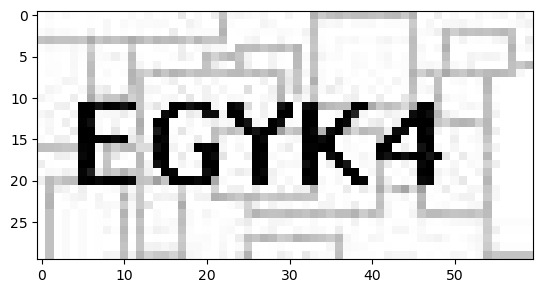

In [6]:
img_file = train_img_list[0]
img = cv2.imread(img_file)
plt.imshow(img)

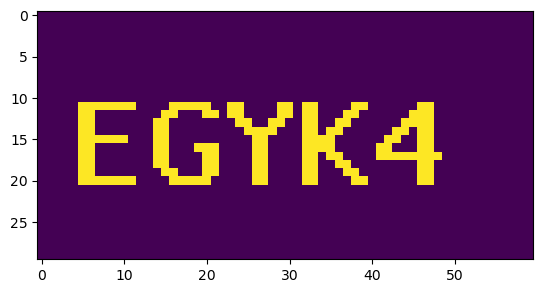

In [7]:
binary = (img[:, :, 0] < threshold).astype(int)
plt.imshow(binary)

- Remove the blank areas by checking whether the sum of its rows or columns equals zero.
- Crop the image into segments containing only one character.

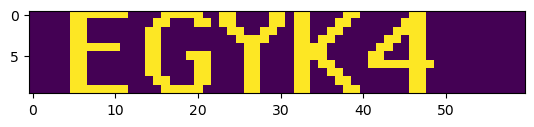

In [8]:
start = 0
end = 0
row_sum = np.sum(binary, axis=1)
for i_r, row in enumerate(row_sum):
    if row:
        if start == 0:
            start = i_r
        else:
            end = i_r
end += 1
binary = binary[start:end, :]
plt.imshow(binary)

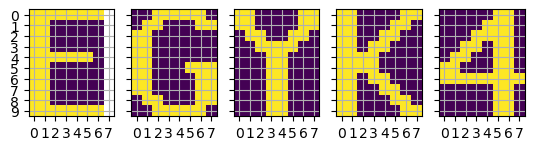

In [9]:
segments = []
start = 0
end = 0
col_sum = np.sum(binary, axis=0)
for i_c, col in enumerate(col_sum):
    if col:
        if start == 0:
            start = i_c
        else:
            end = i_c
    elif end != 0:
        segments.append([start, end+1])
        start = 0
        end = 0
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
for i_char, seg in enumerate(segments):
    axs[i_char].imshow(binary[:, seg[0]:seg[1]])
    axs[i_char].set_xticks(np.arange(0, 8, 1))
    axs[i_char].set_yticks(np.arange(0, 10, 1))
    axs[i_char].grid(True)

## Generate a mapping dictionary between the character segments and the corresponding characters.
- Crop all character's segments in the dataset.
- Check if the same character segment set is used for all images across the dataset.

In [10]:
label2id = {}
id2sample = []
for i, img_path in enumerate(train_img_list):
    img = cv2.imread(img_path)
    output_txt = label_txt_list[i]
    with open(output_txt, 'r') as f:
        label = f.read().strip()
    assert len(label) == 5

    binary = (img[:, :, 0] < threshold).astype(int)
    start = 0
    end = 0
    row_sum = np.sum(binary, axis=1)
    for i_r, row in enumerate(row_sum):
        if row:
            if start == 0:
                start = i_r
            else:
                end = i_r
    end += 1

    binary = binary[start:end, :]
    segments = []
    start = 0
    end = 0
    col_sum = np.sum(binary, axis=0)
    for i_c, col in enumerate(col_sum):
        if col:
            if start == 0:
                start = i_c
            else:
                end = i_c
        elif end != 0:
            segments.append([start, end+1])
            start = 0
            end = 0

    for i_char, seg in enumerate(segments):
        if not label[i_char] in label2id:
            label2id[label[i_char]] = len(id2sample)
            id2sample.append(binary[:, seg[0]:seg[1]])
        else:
            assert seg[1] - seg[0] == id2sample[label2id[label[i_char]]].shape[1]
            assert np.all(id2sample[label2id[label[i_char]]] == binary[:, seg[0]: seg[1]])

id2label = {}
for letter in label2id:
    id2label[label2id[letter]] = letter

## Use the dictionary to identify the images in test dataset
- Crop characters from images in test dataset.
- Compare them with the segments in our character dictionary.
- Combine the mapped characters into string as the predicted result.

In [11]:
for i, img_file in enumerate(test_img_list):
    answer = []
    img = cv2.imread(img_file)
    binary = (img[:, :, 0] < threshold).astype(int)

    start = 0
    end = 0
    row_sum = np.sum(binary, axis=1)
    for i_r, row in enumerate(row_sum):
        if row:
            if start == 0:
                start = i_r
            else:
                end = i_r
    end += 1

    binary = binary[start:end, :]
    segments = []
    start = 0
    end = 0
    col_sum = np.sum(binary, axis=0)
    for i_c, col in enumerate(col_sum):
        if col:
            if start == 0:
                start = i_c
            else:
                end = i_c
        elif end != 0:
            segments.append([start, end+1])
            start = 0
            end = 0

    for i_char, seg in enumerate(segments):
        for i_sample, sample in enumerate(id2sample):
            if seg[1] - seg[0] != sample.shape[1]:
                continue
            if np.all(binary[:, seg[0]:seg[1]] == sample):
                answer.append(id2label[i_sample])
    print(f'Image: {img_file}\tPrediction:', ''.join(answer))

Image: ./sampleCaptchas/input/input100.jpg	Prediction: YMB1Q
Image: ./sampleCaptchas/input/input21.jpg	Prediction: CL69V


- Test with the training data and print the predictions with ground truths
- Calculate the accuracy.

In [12]:
acc_count = 0
for i, img_file in enumerate(train_img_list):
    answer = []
    output_txt = label_txt_list[i]
    with open(output_txt, 'r') as f:
        label = f.read().strip()
    img = cv2.imread(img_file)
    binary = (img[:, :, 0] < threshold).astype(int)

    start = 0
    end = 0
    row_sum = np.sum(binary, axis=1)
    for i_r, row in enumerate(row_sum):
        if row:
            if start == 0:
                start = i_r
            else:
                end = i_r
    end += 1

    binary = binary[start:end, :]
    segments = []
    start = 0
    end = 0
    col_sum = np.sum(binary, axis=0)
    for i_c, col in enumerate(col_sum):
        if col:
            if start == 0:
                start = i_c
            else:
                end = i_c
        elif end != 0:
            segments.append([start, end+1])
            start = 0
            end = 0

    for i_char, seg in enumerate(segments):
        for i_sample, sample in enumerate(id2sample):
            if seg[1] - seg[0] != sample.shape[1]:
                continue
            if np.all(binary[:, seg[0]:seg[1]] == sample):
                answer.append(id2label[i_sample])
    answer = ''.join(answer)
    if label == answer:
        acc_count += 1
    print(f'Image: {img_file}\tLabel: {label}\tPrediction: {answer}')
print(f'Accuracy on training dataset: {100 * acc_count / len(train_img_list): .4f}%')

Image: ./sampleCaptchas/input/input00.jpg	Label: EGYK4	Prediction: EGYK4
Image: ./sampleCaptchas/input/input01.jpg	Label: GRC35	Prediction: GRC35
Image: ./sampleCaptchas/input/input02.jpg	Label: 6O5W1	Prediction: 6O5W1
Image: ./sampleCaptchas/input/input03.jpg	Label: J627C	Prediction: J627C
Image: ./sampleCaptchas/input/input04.jpg	Label: VLI2C	Prediction: VLI2C
Image: ./sampleCaptchas/input/input05.jpg	Label: O1R7Q	Prediction: O1R7Q
Image: ./sampleCaptchas/input/input06.jpg	Label: OYTAD	Prediction: OYTAD
Image: ./sampleCaptchas/input/input07.jpg	Label: ZRMQU	Prediction: ZRMQU
Image: ./sampleCaptchas/input/input08.jpg	Label: N9DQS	Prediction: N9DQS
Image: ./sampleCaptchas/input/input09.jpg	Label: ZGJS3	Prediction: ZGJS3
Image: ./sampleCaptchas/input/input10.jpg	Label: GZMBA	Prediction: GZMBA
Image: ./sampleCaptchas/input/input11.jpg	Label: J14DM	Prediction: J14DM
Image: ./sampleCaptchas/input/input12.jpg	Label: PQ9AE	Prediction: PQ9AE
Image: ./sampleCaptchas/input/input13.jpg	Label: VW